In [7]:
from __future__ import print_function
from ipywidgets import interact, interactive, fixed, interact_manual
import ipywidgets as widgets
from sys import path
path.append('..')
path.append('../stationsim')

import ffmpeg
from stationsim.stationsim_model import Model
from stationsim.ukf import *
from stationsim.ukf_aggregate import *


from IPython.display import Video


## Unscented Kalman Filter

Using our established agent based model StationSim we wish to try and filter noisy measurements and improve prediction of agent positions. One such filter that can be used is the Unscented Kalman Filter. This filter was originially designed to apply traditional Kalman Filtering to non-linear functions and we wish to see if it is viable for StationSim as well.

In [8]:
""" 
width            - corridor width
height           - corridor height
pop_total        - population total
entrances        - how many entrances
entrance speed   - mean entry speed for agents
exits            - how many exits
exit_space       - how wide are exits 
speed_min        - minimum agents speed to prevent ridiculuous iteration numbers
speed_mean       - desired mean of normal distribution of speed of agents
speed_std        - as above but standard deviation
speed_steps      - how many levels of speed between min and max for each agent
separation       - agent size (radius) to determine collisions
wiggle           - how far an agent tries to move when it cannot move at all 
                       due to collisions and "wiggles" either left or right
batch_iterations - how many model steps to do as a maximum
do_history/print - whether to record histories or print results of stationsim
"""
model_params = {
        'pop_total': 10,

        'width': 200,
        'height': 100,

        'gates_in': 3,
        'gates_out': 2,
        'gates_space': 1,
        'gates_speed': 1,

        'speed_min': .2,
        'speed_mean': 1,
        'speed_std': 1,
        'speed_steps': 3,

        'separation': 5,
        'max_wiggle': 1,

        'step_limit': 3600,

        'do_history': True,
        'do_print': True,
    }
"""
Sensor_Noise  - how reliable are measurements H_x. lower value implies more reliable.
Process_Noise - how reliable is prediction fx lower value implies more reliable

sample_rate   - how often to update kalman filter. higher number gives smoother predictions. lowest is 1.
do_restrict   - restrict to a proportion prop of the agents being observed
do_animate    - bools for doing animations of agent/wiggle aggregates
prop          - proportion of agents observed. this is a floor function that rounds the proportion 
                    DOWN to the nearest intiger number of agents. 1 is all <1/pop_total is none
heatmap_rate  - after how many updates to record a frame
bin_size      - square sizes for aggregate plots (not used here)
do_batch      - do batch processing on some pre-recorded truth data. (not implemented yet)
"""

filter_params = {      

        "Sensor_Noise":  1, 
        "Process_Noise": 1, 
        'sample_rate': 50,
        "do_restrict": True, 
        "do_animate": True,
        "prop": 0.5,
        "heatmap_rate": 1,
        "bin_size":10,
        "bring_noise":True,
        "noise":0.5,
        "do_batch":False,
        }

"""
a - alpha between 1 and 1e-4 typically determines spread of sigma points. 
        For high dimensional states (>10) anything less than 1 usually causes some instability
b - beta set to 2 for gaussian. determines trust in prior distribution.
k - kappa usually 0 for state estimation and 3-(dim(state)) for parameter estimation.
"""

ukf_params = {
        "a":1,
        "b":2,
        "k":0,
        }



In [9]:
"initiate StationSim"
base_model = Model(**model_params)
"initiate UKF"
u = ukf_ss(model_params = model_params,filter_params = filter_params,ukf_params = ukf_params,base_model=base_model)
"run UKF main. iterate station sim and track agent locations"
u.main()



	Iteration: 0/3600
	Iteration: 100/3600
	Iteration: 200/3600
	Iteration: 300/3600
	Iteration: 400/3600
	Iteration: 500/3600
	Iteration: 600/3600
	Iteration: 700/3600
	Iteration: 800/3600
0:09:00.181859


ValueError: too many values to unpack (expected 2)

../stationsim/ukf.py:539: RuntimeWarning: Mean of empty slice
  time_means = np.nanmean(c,axis=1)


3
0


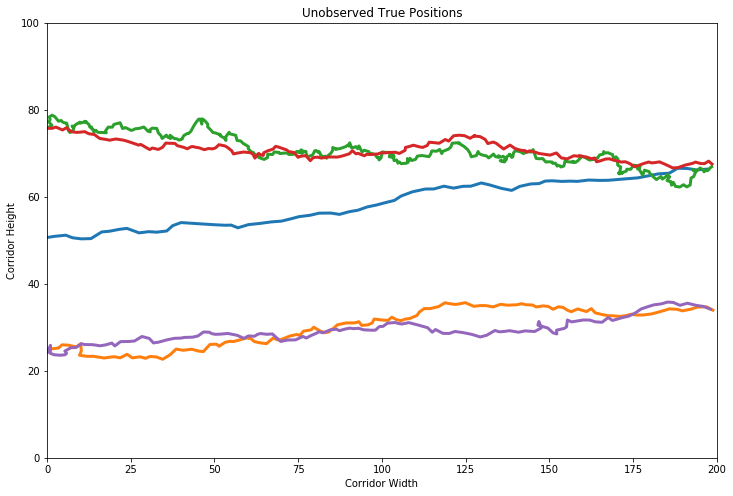

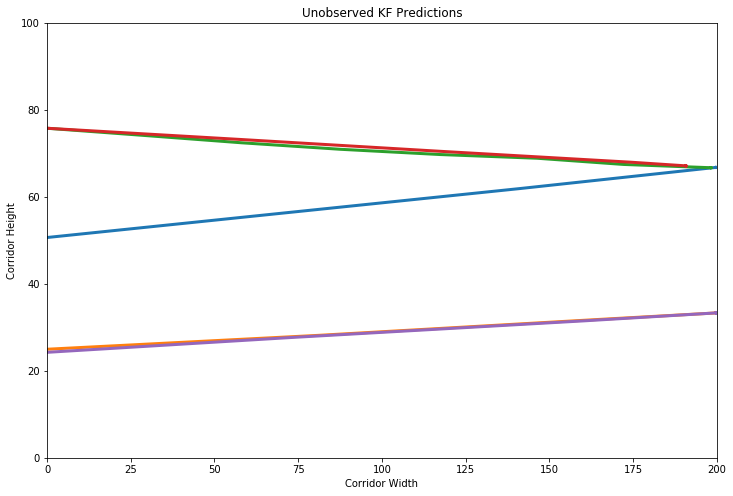

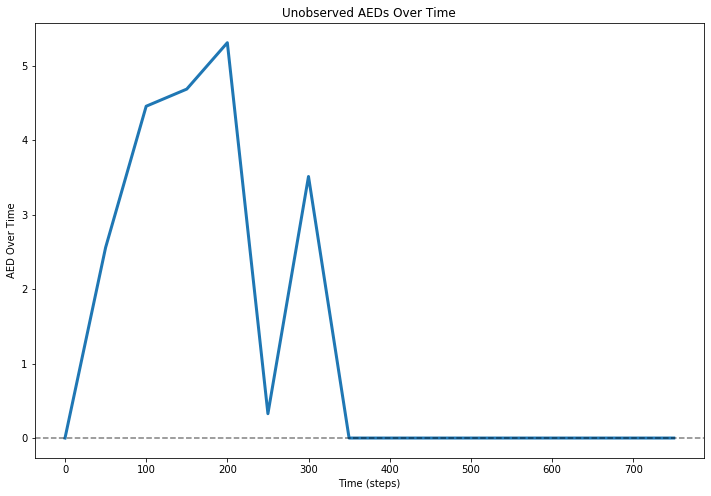

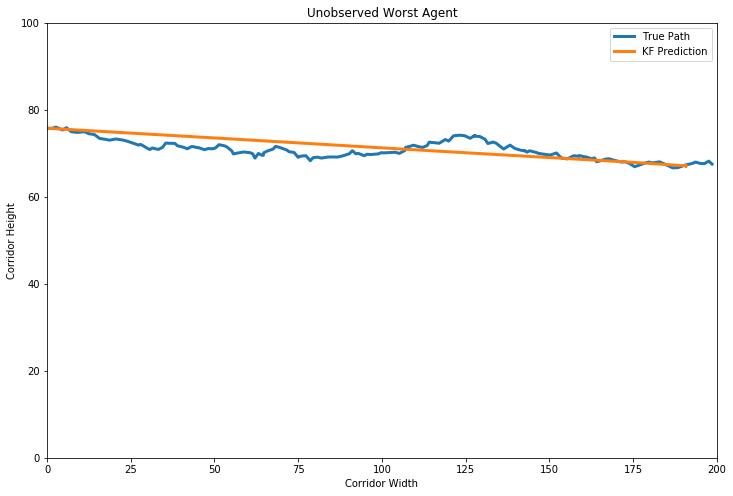

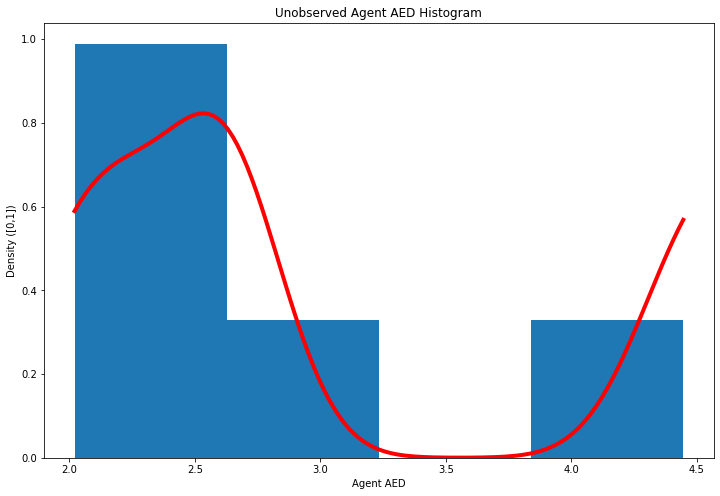

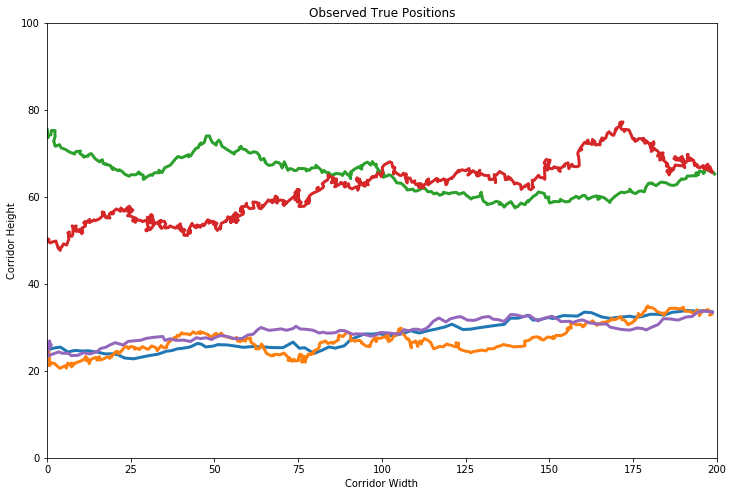

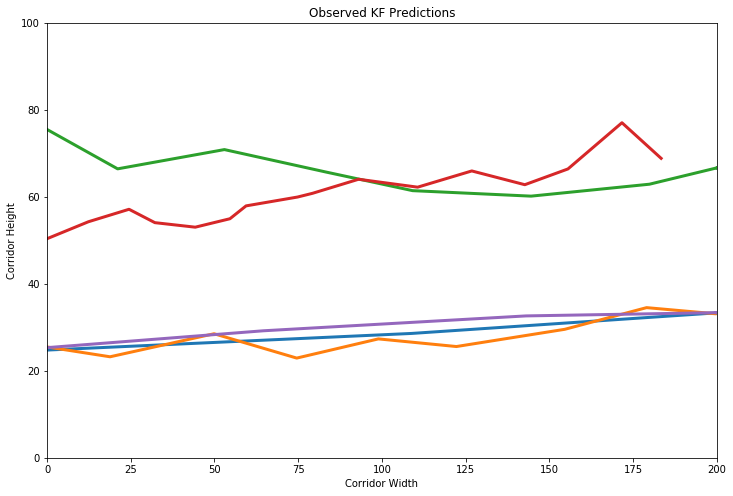

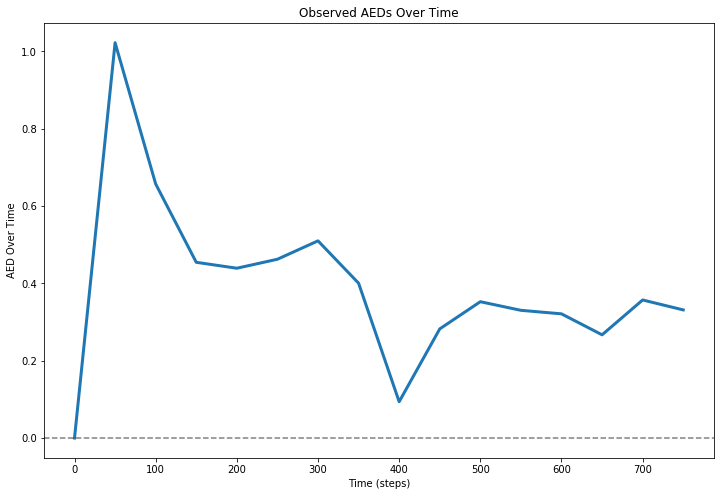

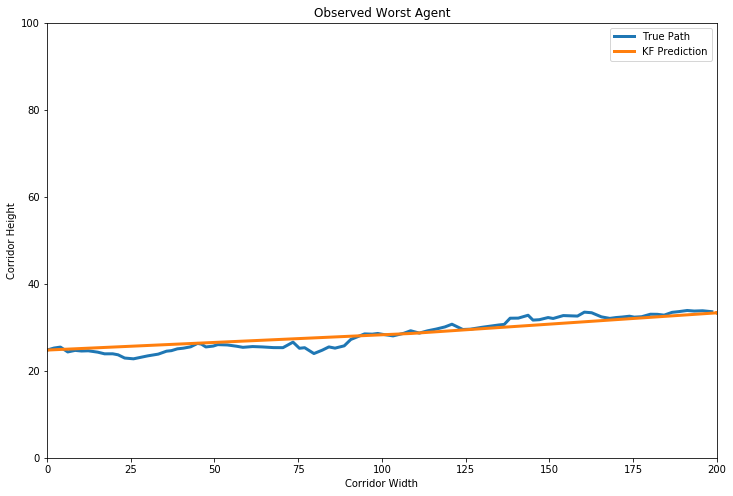

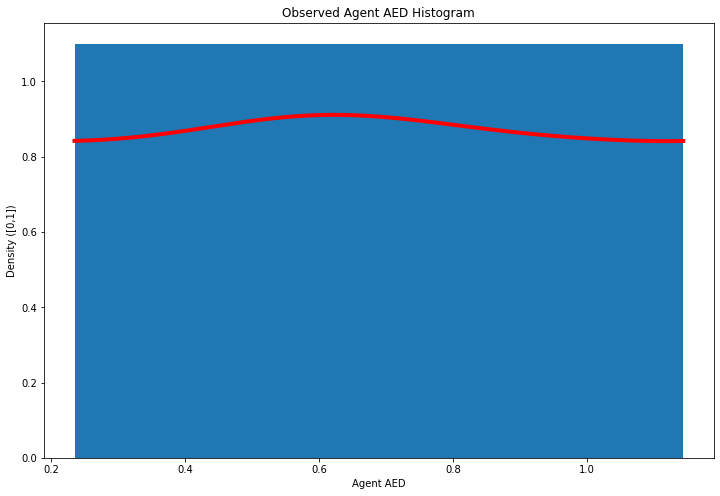

In [10]:
if filter_params["sample_rate"]>1:
    actual,preds,full_preds= u.data_parser(True)
else:
    actual,preds,full_preds= u.data_parser(True)

actual = actual[1:,:] #cut off wierd n/a start from StationSim

"initiate plot class using final instance of UKF. easier to do this that import numerous variables"
plts = plots(u)

"diagnostic plots, error matrices, and MAE over time"
if filter_params["prop"]<1 or filter_params["do_unobserved"]:
    distances,t_mean = plts.diagnostic_plots(actual,preds,False,False) #unobserved
distances2,t_mean2 = plts.diagnostic_plots(actual,preds,True,False) #observed

In [14]:
if filter_params["sample_rate"]==1:
    #plts.pair_frames(actual,preds)
    #plts.heatmap(actual)
    plts.pair_frames_stack_ellipse(actual,preds)

else:
    plts.pair_frames(actual,full_preds)
    #plts.pair_frames_stack_ellipse(actual,full_preds)
    #plts.heatmap(actual)
    
print ("mp4 saved in:" + str(os.getcwd()) )

pop_total = model_params["pop_total"]
f_name = f'pairwise_gif_{pop_total}GIF.mp4'
Video(f_name)

845 frames generated.
mp4 saved in:/home/rob/dust/Projects/ABM_DA/experiments
